In [46]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import RobustScaler, StandardScaler,MinMaxScaler, FunctionTransformer, OneHotEncoder, Normalizer
from src.pipelines import get_pipeline, get_data_preparation_pipeline
from src.loaders.data_loader import get_train_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, f1_score
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
from category_encoders import LeaveOneOutEncoder, BinaryEncoder, TargetEncoder
import pandas as pd
import joblib
import seaborn as sns
import numpy as np
from src.transformation_utils.select_columns import SelectColumns
%matplotlib inline

In [2]:
#TODO: try some features importances, scalers and models

In [3]:
features = [
    "Census_MDC2FormFactor",
    "Census_DeviceFamily",
    "Census_OEMNameIdentifier",
    "Census_OEMModelIdentifier",
    "Census_ProcessorCoreCount",
    "Census_ProcessorManufacturerIdentifier",
    "Census_ProcessorModelIdentifier",
    "Census_ProcessorClass",
    "Census_PrimaryDiskTotalCapacity",
    "Census_PrimaryDiskTypeName",
    "Census_SystemVolumeTotalCapacity",
    "Census_HasOpticalDiskDrive",
    "Census_TotalPhysicalRAM",
    "Census_ChassisTypeName",
    "Census_InternalPrimaryDiagonalDisplaySizeInInches",
    "Census_InternalPrimaryDisplayResolutionHorizontal",
    "Census_InternalPrimaryDisplayResolutionVertical",
    "Census_GenuineStateName",
    "Census_ActivationChannel",
    "Census_FirmwareManufacturerIdentifier",
    "Census_FirmwareVersionIdentifier",
    "Census_IsTouchEnabled",
    "Census_IsPenCapable",
    "Census_IsAlwaysOnAlwaysConnectedCapable",
    "Wdft_IsGamer"
]

In [4]:
X, y = get_train_data(sample_size=0.005)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [105]:
columns_numeric_hardware_features =["Census_TotalPhysicalRAM",
                       "Census_ProcessorCoreCount",
                       "Census_PrimaryDiskTotalCapacity",
                       "Census_SystemVolumeTotalCapacity"
                       ]

categorial_features = [
    "Census_MDC2FormFactor",
    "Census_ActivationChannel",
    "Census_GenuineStateName",
    #"Census_IsTouchEnabled",
    #"Census_IsPenCapable",
    #"Census_IsAlwaysOnAlwaysConnectedCapable",
    "Wdft_IsGamer",
    "SmartScreen"
]

identifier_features = [
    "Census_OEMNameIdentifier",
    #"Census_OEMModelIdentifier",
    #"Census_ProcessorManufacturerIdentifier",
    #"Census_ProcessorModelIdentifier",
    #"Census_FirmwareManufacturerIdentifier",
    #"Census_FirmwareVersionIdentifier",
]

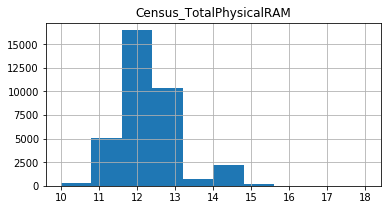

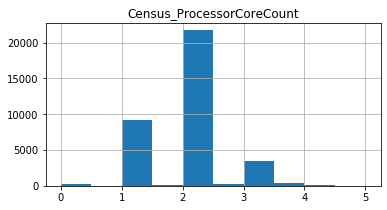

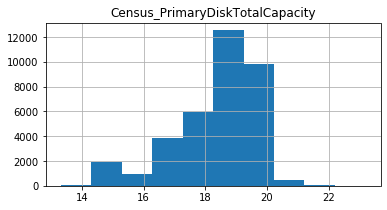

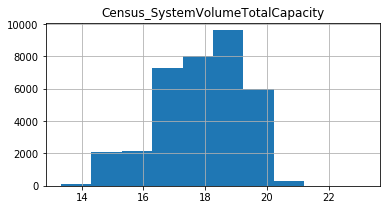

In [106]:
for column in columns_numeric_hardware_features:
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.set_title(column)
    np.log2(X_train[column]).hist()
    plt.show()

In [ ]:
def check_pipeline_performance(pipeline, X_test, y_test):
    class_names = ["No","Yes"]
    disp = plot_confusion_matrix(pipeline, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.YlOrRd,
                                 normalize='true')

    disp.ax_.set_title("Model performance")

    print("Model performance")
    
    print(disp.confusion_matrix)

    plot_roc_curve(pipeline, X_test, y_test)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    plt.show()
    plot_precision_recall_curve(pipeline, X_test, y_test)
    
    y_pred = pipeline.predict(X_test)
    score = f1_score(y_test, y_pred)
    
    print(f"f1 score: {score}")
    plt.show()

In [89]:
#TODO: select the best scaler: MinMax, Standard, or Rubust

In [90]:
preparation_pipeline_numeric_hardware = make_union(
    make_pipeline(
            SelectColumns(columns_numeric_hardware_features),
            SimpleImputer(missing_values=np.nan, strategy="median"),
            SimpleImputer(missing_values=-1, strategy="median"),
            StandardScaler()
    ),
    make_pipeline(
            SelectColumns(columns_numeric_hardware_features),
            SimpleImputer(missing_values=np.nan, strategy="median"),
            SimpleImputer(missing_values=-1, strategy="median"),
            FunctionTransformer(np.log2),
            StandardScaler()
    )
)
    
fitted = preparation_pipeline_numeric_hardware.fit_transform(X_train, y_train)
log_names = [column+"_log" for column in columns_numeric_hardware_features]
columns_to_check = columns_numeric_hardware_features + log_names
fitted_df = pd.DataFrame(fitted, columns=columns_to_check)
fitted_df.head()

,Census_TotalPhysicalRAM,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM_log,Census_ProcessorCoreCount_log,Census_PrimaryDiskTotalCapacity_log,Census_SystemVolumeTotalCapacity_log
0,-0.411790,0.008734,-0.103153,0.255350,-0.362779,0.236952,0.264777,0.614100
1,1.284247,0.008734,1.236906,1.778150,1.528273,0.236952,1.000749,1.359514
2,-0.411790,-1.005646,-0.103153,0.262712,-0.362779,-1.326517,0.264777,0.619393
3,-0.411790,-1.005646,-0.103153,0.306525,-0.362779,-1.326517,0.264777,0.650338
4,12.308491,8.123781,-0.070992,0.343469,4.409705,3.867213,0.289958,0.675722


In [91]:
fitted_df["HasDetections"] = y_train

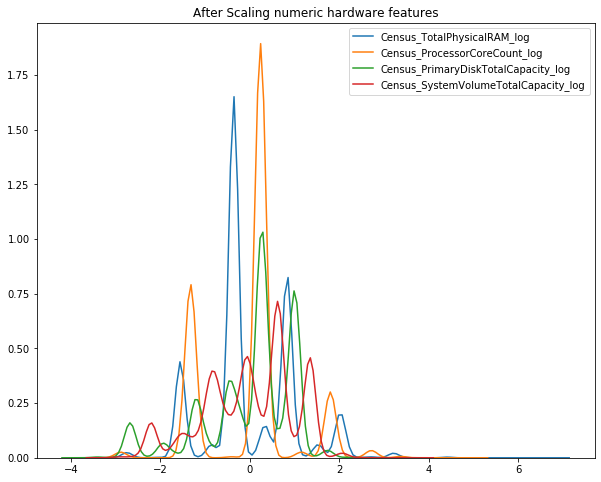

In [92]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After Scaling numeric hardware features')
for column in columns_to_check:
    if column.endswith("_log"):
        sns.kdeplot(fitted_df[column], ax=ax1)
#fitted_df.hist()
#joblib.dump(pipeline,"model.joblib")

In [93]:
print(fitted_df[fitted_df["HasDetections"] == 1].mean())
print(fitted_df[fitted_df["HasDetections"] == 0].mean())

Census_TotalPhysicalRAM                -0.004107
Census_ProcessorCoreCount               0.008308
Census_PrimaryDiskTotalCapacity        -0.018656
Census_SystemVolumeTotalCapacity       -0.009356
Census_TotalPhysicalRAM_log            -0.007396
Census_ProcessorCoreCount_log           0.005920
Census_PrimaryDiskTotalCapacity_log    -0.015401
Census_SystemVolumeTotalCapacity_log   -0.006950
HasDetections                           1.000000
dtype: float64
Census_TotalPhysicalRAM                 0.005334
Census_ProcessorCoreCount              -0.005910
Census_PrimaryDiskTotalCapacity         0.012807
Census_SystemVolumeTotalCapacity        0.008069
Census_TotalPhysicalRAM_log             0.003845
Census_ProcessorCoreCount_log          -0.002286
Census_PrimaryDiskTotalCapacity_log     0.014757
Census_SystemVolumeTotalCapacity_log    0.007237
HasDetections                           0.000000
dtype: float64


In [94]:
fitted_with_y = fitted_df
fitted_with_y["HasDetections"] = y_train
fitted_with_y.corr()

,Census_TotalPhysicalRAM,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM_log,Census_ProcessorCoreCount_log,Census_PrimaryDiskTotalCapacity_log,Census_SystemVolumeTotalCapacity_log,HasDetections
Census_TotalPhysicalRAM,1.000000,0.577612,0.162502,0.159921,0.847392,0.508432,0.145873,0.180049,-0.004656
Census_ProcessorCoreCount,0.577612,1.000000,0.118041,0.087546,0.571858,0.933538,0.079541,0.090922,0.007104
Census_PrimaryDiskTotalCapacity,0.162502,0.118041,1.000000,0.767620,0.263110,0.154107,0.858389,0.693694,-0.015750
Census_SystemVolumeTotalCapacity,0.159921,0.087546,0.767620,1.000000,0.249352,0.110148,0.658189,0.868433,-0.008698
Census_TotalPhysicalRAM_log,0.847392,0.571858,0.263110,0.249352,1.000000,0.570243,0.288880,0.310128,-0.005608
Census_ProcessorCoreCount_log,0.508432,0.933538,0.154107,0.110148,0.570243,1.000000,0.115652,0.114581,0.004109
Census_PrimaryDiskTotalCapacity_log,0.145873,0.079541,0.858389,0.658189,0.288880,0.115652,1.000000,0.803523,-0.015136
Census_SystemVolumeTotalCapacity_log,0.180049,0.090922,0.693694,0.868433,0.310128,0.114581,0.803523,1.000000,-0.007103
HasDetections,-0.004656,0.007104,-0.015750,-0.008698,-0.005608,0.004109,-0.015136,-0.007103,1.000000


In [95]:
not_fitted_with_y = X_train[columns_numeric_hardware_features]
not_fitted_with_y["HasDetections"] = y_train
not_fitted_with_y.corr()

/home/yaron/anaconda3/envs/microsoft-challenge/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Census_TotalPhysicalRAM,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,HasDetections
Census_TotalPhysicalRAM,1.000000,0.579361,0.161911,0.158847,0.055729
Census_ProcessorCoreCount,0.579361,1.000000,0.118401,0.087987,0.057969
Census_PrimaryDiskTotalCapacity,0.161911,0.118401,1.000000,0.767734,0.046332
Census_SystemVolumeTotalCapacity,0.158847,0.087987,0.767734,1.000000,0.009123
HasDetections,0.055729,0.057969,0.046332,0.009123,1.000000


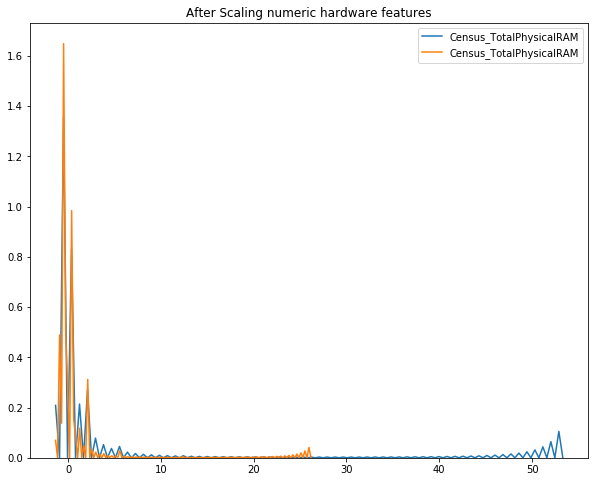

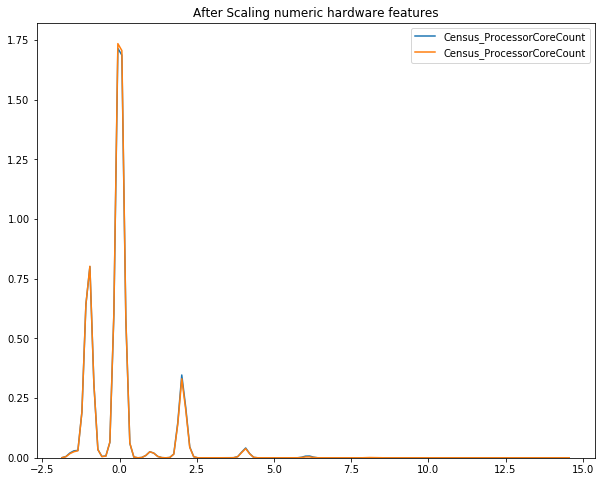

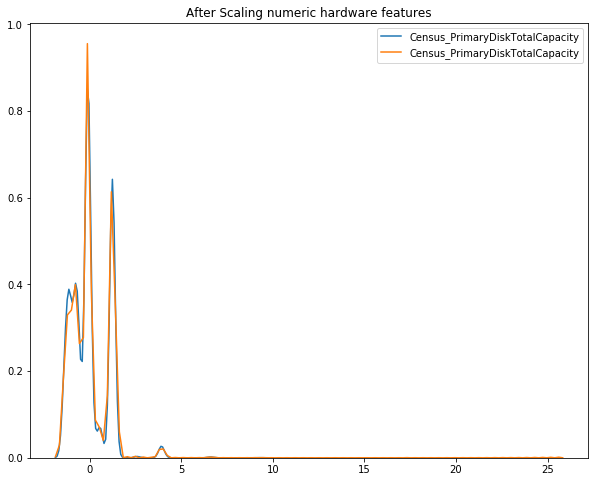

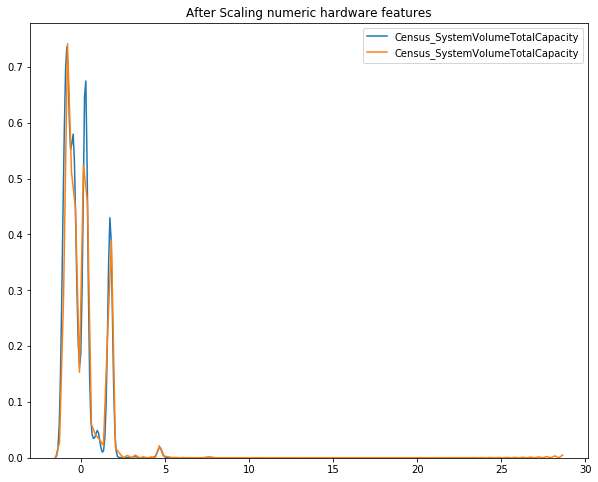

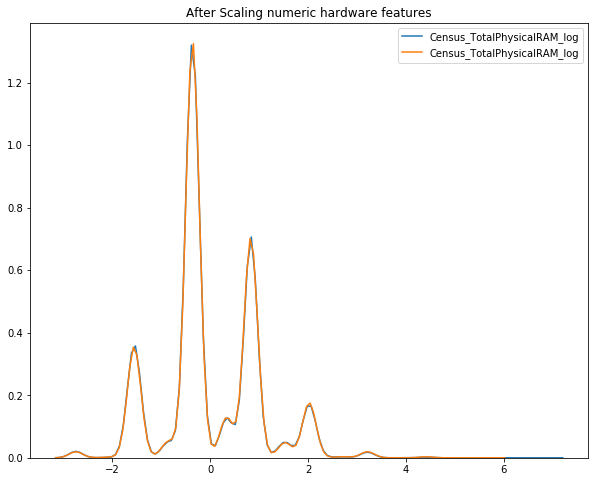

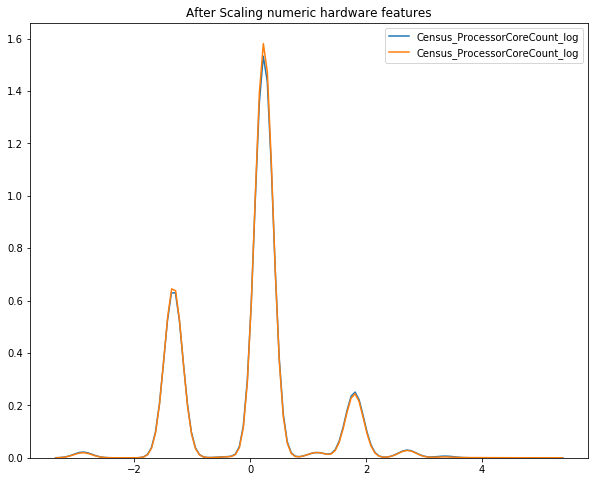

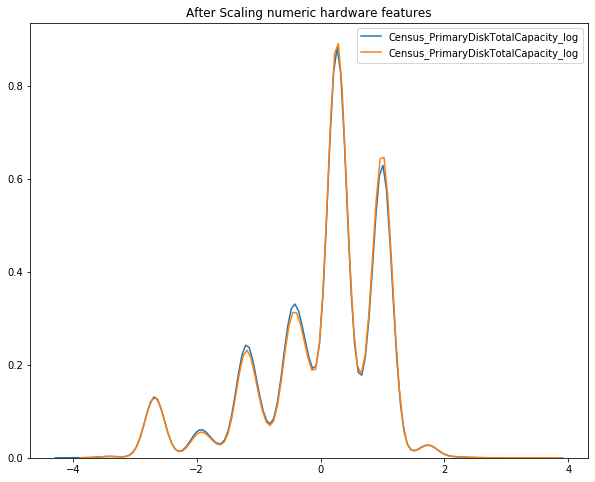

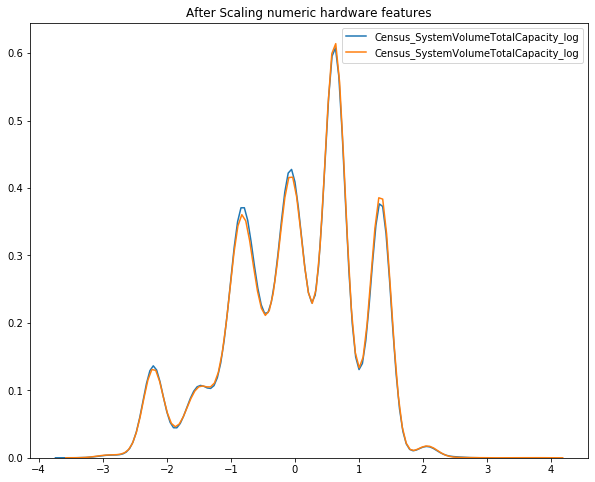

In [96]:
for column in columns_to_check:
    fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
    ax1.set_title('After Scaling numeric hardware features')
    sns.kdeplot(fitted_df[fitted_df["HasDetections"] == 1][column], ax=ax1)
    sns.kdeplot(fitted_df[fitted_df["HasDetections"] == 0][column], ax=ax1)
    

In [97]:
#TODO: check this

def features_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

#svm = SVC(C=1.0, kernel='linear')
full_pipeline = make_pipeline(
    preparation_pipeline_numeric_hardware,
    SVC(C=1.0, kernel='linear')
)
#X_transformed = preparation_pipeline_numeric_hardware.fit_transform(X_train, y_train)
#svm = full_pipeline.named_steps["svm"]
#svm = svm.fit(X_transformed, y_train)
#feature_importances(svm.coef_, features_names)
#check_pipeline_performance(full_pipeline, X_test, y_test)

In [98]:
#TODO: check correlation between categorial features

In [107]:
classifiers = {
    "random_forest": RandomForestClassifier(),
    "svm_c1": SVC(C=1.0, kernel='rbf'),
    "svm_c10": SVC(C=10.0, kernel='rbf')
}

random_forest
Model performance
[[0.51175166 0.48824834]
 [0.47306474 0.52693526]]


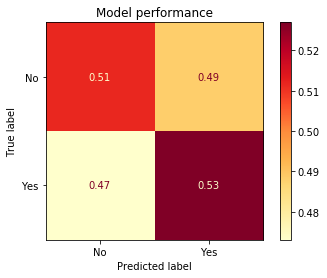

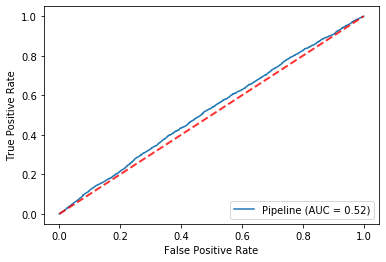

f1 score: 0.5203397407241841
svm_c1
Model performance
[[0.54345898 0.45654102]
 [0.45337257 0.54662743]]


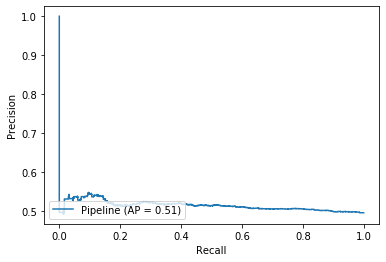

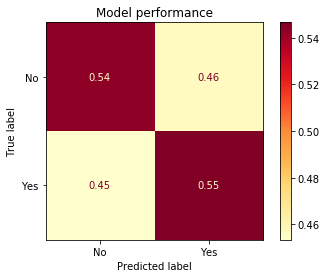

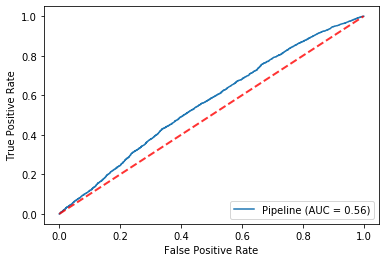

f1 score: 0.5431848852901484
svm_c10
Model performance
[[0.53303769 0.46696231]
 [0.4370756  0.5629244 ]]


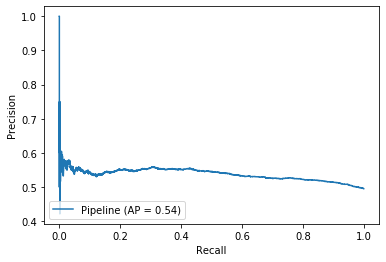

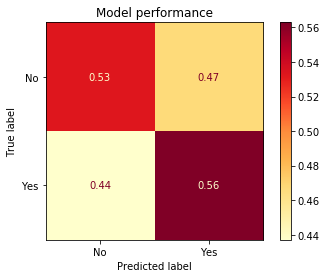

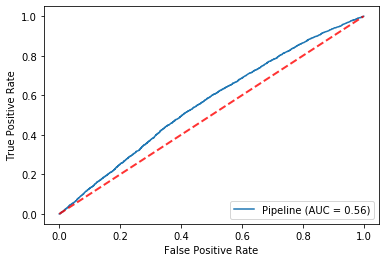

f1 score: 0.5519920097658417


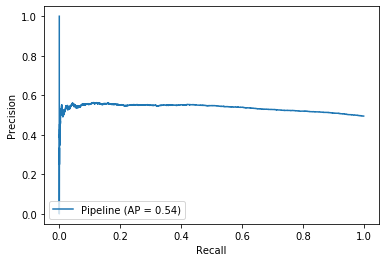

In [112]:
for classifier_name, classifier in classifiers.items():
    print(classifier_name)
    full_pipeline = make_pipeline( 
        make_union(
            preparation_pipeline_numeric_hardware,
#             make_pipeline(
#                SelectColumns(categorial_features),
#                SimpleImputer(strategy='most_frequent'),
#                OneHotEncoder()
#             ),
#             make_pipeline(
#                SelectColumns(identifier_features),
#                SimpleImputer(strategy='most_frequent'), #problematic
#                TargetEncoder()
#             )
        ),
        #Normalizer(),
        #TruncatedSVD(n_components=8),
        classifier
    )
    full_pipeline = full_pipeline.fit(X_train, y_train)
    check_pipeline_performance(full_pipeline, X_test, y_test)

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = [‘red’ if c < 0 else ‘blue’ for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha=’right’)
 plt.show()
cv = CountVectorizer()
cv.fit(data)
X_train = cv.transform(data)

svm = LinearSVC()
svm.fit(X_train, target)
plot_coefficients(svm, cv.get_feature_names())

In [ ]:
fitted_df.describe()

In [ ]:
pipeline = get_pipeline()
pipeline = pipeline.fit(X_train, y_train)
pipeline 

In [ ]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
f_importances(pipeline.coef_, features_names=["Y","X","Z"])

In [ ]:
pipeline.pic

In [ ]:
preparation_pipeline = get_data_preparation_pipeline()
X_transformed = preparation_pipeline.fit_transform(X_train, y_train)

In [ ]:
X_transformed.shape
df = pd.DataFrame.sparse.from_spmatrix(X_transformed)
df
df['HasDetections'] = y_train

corr = df.corr()
fig, ax = plt.subplots(figsize=(16, 12))
ax = sns.heatmap(corr, annot=True, ax=ax)
ax.set_title("Pearson Correlation between Variables")
ax